In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import os
import numpy as np
import string
from six.moves import range
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle
import matplotlib

In [2]:
folder_name = 'simple_model'
pickle_file_1 = 'simple_1.pickle'
pickle_file_2 = 'simple_2.pickle'

with open(folder_name + '/' + pickle_file_1, 'rb') as f:
  save = pickle.load(f)
  results1_GL = save['results1_GL']
  del save  # hint to help gc free up memory

with open(folder_name + '/' + pickle_file_2, 'rb') as f:
  save = pickle.load(f)
  results2_GL = save['results2_GL']
  del save  # hint to help gc free up memory

In [3]:
indices_GL = {"batch_size": 0,
              "num_unrollings": 1,
              "num_layers": 2,
              "num_nodes": 3,
              "half_life": 4,
              "decay": 5,
              "num_steps": 6,
              "averaging_number": 7,
              "type": 8}

for i in range(len(results1_GL)):
    results1_GL[i]['metadata'].append('simple')

for i in range(len(results2_GL)):
    results2_GL[i]['metadata'].append('simple')

In [4]:


class ComparePlots(object):
    _networks_dictionary = dict()
    _folder_for_plots = ""
    colors = {0: 'k',
              1: 'blue',
              2: '#E24A33',
              3: 'green',
              4: 'cyan',
              5: 'gray',
              6: 'm',
              7: 'firebrick',
              8: 'darkgoldenrod',
              9: 'purple',
              10: 'magenta',
              11: 'r',
              12: 'yellow',
              13: '#92C6FF', 
              14: '#0072B2',
              15: '#30a2da',
              16: '#4C72B0',
              17: '#8EBA42',
              18: '#6d904f'} 
    font = {'family' : 'normal',
            'weight' : 'bold',
            'size'   : 12}
    default_fig_num = 1
    def __init__(self, folder_name):
        self._folder_for_plots = folder_name
        matplotlib.rc('font', **self.font)
    
    def add_network(self, results, indices, key=None):
        if key is None:
            key = self._make_key(results, 0, indices)
        if key not in self._networks_dictionary.keys():
            self._networks_dictionary[key] = {'indices': dict(indices), 'results': list(results)}
        else:
            print("Network with such structure is already present")
            if self._networks_dictionary[key]['indices'] == indices:
                self._networks_dictionary[key]['results'].extend(results)
            else:
                print("'indices' variable has different structure")
                counter = 0
                while (key + ("_#%s" % counter)) in self._networks_dictionary.keys():
                    counter += 1
                self._networks_dictionary[key + ("_#%s" % counter)] = {'indices': indices, 'results': results}
        
    def _make_key(self, results, result_number, indices):
        if results[result_number]['metadata'][indices["type"]] == 'simple':
            return results[result_number]['metadata'][indices["type"]] + ("_%s" % results[result_number]['metadata'][indices["num_layers"]])
        elif results[result_number]['metadata'][indices["type"]] == 'simple_gf':
            return results[result_number]['metadata'][indices["type"]] + ("_%s" % results[result_number]['metadata'][indices["num_layers"]])
        elif results[result_number]['metadata'][indices["type"]] == 'reverse':
            return results[result_number]['metadata'][indices["type"]] + ("_%s" % results[result_number]['metadata'][indices["num_layers"]])            
        else:
            print("Unknown network type: %s" % results[result_number]['metadata'][indices["type"]])
            return 0
        
    def print_networks_keys(self):
        for key in self._networks_dictionary.keys():
            print(key)
            
    def get_networks_keys(self):
        return self._networks_dictionary.keys()
    
    def remove_network(self, key):
        if key in self._networks_dictionary.keys():
            del self._networks_dictionary[key]
        else:
            print("Wrong key")
            
    def print_folder_name(self):
        print("folder for plots: ", self._folder_for_plots)
        
    def set_folder_name(folder_name):
        self._folder_for_plots = folder_name
        
    def get_folder_name(self):
        return self._folder_for_plots       
    
    def print_metadata_structure(self, key):
        if key in self._networks_dictionary.keys():
            print("'%s' metadata structure:" % key)
            for index_key in self._networks_dictionary[key]["indices"].keys():
                print(index_key)    
        else:
            print("Wrong key")
    
    def get_metadata_structure(self, key):
        if key in self._networks_dictionary.keys(): 
            return self._networks_dictionary[key]["indices"].keys()
        else:
            print("Wrong key")
            
    def _parse_one_variable(self, variable):
        if isinstance(variable, basestring):
            if variable[-1] == ']':
                [variable, index] = variable.split('[')
                index = int(index[:len(index)-1])
                return (variable, index)
            else:
                return (variable, None)
        if isinstance(variable, tuple):
            return variable
        else:
            return None
        
        
    def _parse_variables(self, variables):
        if isinstance(variables, list):
            variables_list = list()
            for var in variables:
                variables_list.append(self._parse_one_variable(var))
            return variables_list
        if isinstance(variables, dict):
            variables_dict = dict()
            for var in variables.keys():
                variables_dict[self._parse_one_variable(var)] = variables[var]
            return variables_dict
        if variables is None:
            return None
        else:
            return self._parse_one_variable(variables)

    def _reverse_one_parse(self, variable):
        if isinstance(variable, tuple):
            if variable[1] is None:
                return variable[0]
            else:
                return variable[0] + ('[%s]' % variable[1])
        else:
            print("ERROR! (in _reverse_one_parse):\n'variable' parameter has to be tuple")
            return None
        
    def _reverse_parse(self, variables):
        if isinstance(variables, list):
            return [self._reverse_one_parse(variable) for variable in variables]
        else:
            return self._reverse_one_parse(variables)
            
    def _get_variable_values(self, key, variable):
        results = self._networks_dictionary[key]['results']
        indices = self._networks_dictionary[key]['indices']
        runs_number = len(results)  
        values = list()
        variable = self._parse_variables(variable)
        if variable[0] not in indices.keys():
            print("Variable '%s' is not in '%s' network metadata" % (variable[0], key))
            return 0
        else:
            for run_number in range(runs_number):
                if variable[1] is not None:
                    new_value = results[run_number]['metadata'][indices[variable[0]]][variable[1]]
                else:
                    new_value = results[run_number]['metadata'][indices[variable[0]]]
                if new_value not in values:
                    values.append(new_value)
            values.sort()
            return values
        
    def _modify_other_variables(self, other, metadata, indices):
        if other['counter'] == 0:
            for other_variable in other['variables'].keys():
                if other_variable[1] is None:
                    other['variables'][other_variable][0] = metadata[indices[other_variable[0]]]
                else:
                    other['variables'][other_variable][0] += metadata[indices[other_variable[0]]][other_variable[1]]
        else:
            for other_variable in other['variables'].keys():
                if other_variable[1] is None:
                    if other['variables'][other_variable][1]:
                        other['variables'][other_variable][0] += metadata[indices[other_variable[0]]]
                    elif other['variables'][other_variable][0] != metadata[indices[other_variable[0]]]:
                        other['variables'][other_variable][0] *= other['counter']
                        other['variables'][other_variable][0] += metadata[indices[other_variable[0]]]
                        other['variables'][other_variable][1] = True
                else:       
                    if other['variables'][other_variable][1]:
                        other['variables'][other_variable][0] += metadata[indices[other_variable[0]]][other_variable[1]]
                    elif other['variables'][other_variable][0] != metadata[indices[other_variable[0]]][other_variable[1]]:
                        other['variables'][other_variable][0] *= other['counter']
                        other['variables'][other_variable][0] += metadata[indices[other_variable[0]]][other_variable[1]]
                        other['variables'][other_variable][1] = True
        other['counter'] += 1
        return other
        
        
    def _create_data_for_layout_plot(self,
                                     key,
                                     x_variable,
                                     layout_variable,
                                     fixed=None,
                                     other_variables=None,
                                     averaging=True,
                                     percentage=True,
                                     alternative_variable=None):
        results = self._networks_dictionary[key]['results']
        indices = self._networks_dictionary[key]['indices']
        runs_number = len(results) 
        
        x_variable = self._parse_variables(x_variable)
        layout_variable = self._parse_variables(layout_variable)
        other_variables = self._parse_variables(other_variables)
        
        proposed_variables = list()
        if isinstance(layout_variable, dict):
            proposed_variables.extend(layout_variable.keys())
        else:
            if layout_variable is not None:
                proposed_variables.append(layout_variable)
        if x_variable is not None:
            proposed_variables.append(x_variable)
        
        alternative_variable = self._parse_variables(alternative_variable)
        if alternative_variable is not None:
            proposed_variables.append(alternative_variable)
            
        if fixed is not None:
            fixed = self._parse_variables(fixed)
            proposed_variables.extend(fixed.keys())
        for variable in proposed_variables:
            if variable[0] not in indices.keys():
                print("Variable '%s' is not in '%s' network metadata" % (variable[0], key))
                return 0

        if fixed is not None:
            for fixed_var in fixed.keys():
                fixed_var_values = self._get_variable_values(key, fixed_var)
                if fixed[fixed_var] not in fixed_var_values:
                    print("Variable '%s' does not take value '%s'" % (fixed_var[0], fixed[fixed_var]))
                    return 0
        if not isinstance(layout_variable, dict):
            if layout_variable is not None:
                layout_values = self._get_variable_values(key, layout_variable)
            else:
                layout_values = None
        
        if isinstance(layout_variable, dict):
            data_for_plot = {'fixed': fixed,
                             'layout_variable': layout_variable.keys(),
                             'x_variable': x_variable,
                             'data': list(),
                             'several_networks': False}  
        else:
            data_for_plot = {'fixed': fixed,
                             'layout_variable': layout_variable,
                             'x_variable': x_variable,
                             'data': list(),
                             'several_networks': False}
        if x_variable is None:
            data_for_plot['x_variable'] = ('steps', None)
            
        if other_variables is None:
            other_variables = {('num_steps', None): [0, False],
                               ('half_life', None): [0, False],
                               ('decay', None): [0, False]}
            other = {'counter': 0, 'variables': other_variables}
        else:
            new_other_variables = dict()
            for other_variable in other_variables:
                new_other_variables[other_variable] = [0, False]
            other = {'counter': 0, 'variables': new_other_variables}
                
        if isinstance(layout_variable, dict):
            for layout_key in data['layout_variable']:
                data_for_plot['data'].append({'layout_value': layout_variable[layout_key],  'x': list(), 'y': list(), 'frequency': list()})
        else:
            if layout_values is not None:
                for layout_value in layout_values:
                    data_for_plot['data'].append({'layout_value': layout_value,  'x': list(), 'y': list(), 'frequency': list()})
            else:
                data_for_plot['data'].append({'layout_value': None,  'x': list(), 'y': list(), 'frequency': list()})

        for run_number in range(runs_number):
            metadata = results[run_number]['metadata']
            XDATA = results[run_number]['data']['train']['step']
            YDATA = results[run_number]['data']['train']['percentage']
            this_run_fits = True
            if fixed is not None:
                fixed_vars = fixed.keys()
                for fixed_var in fixed_vars:
                    if fixed_var[1] is None:
                        if metadata[indices[fixed_var[0]]] != fixed[fixed_var]:
                            this_run_fits = False
                    else:
                        if metadata[indices[fixed_var[0]]][fixed_var[1]] != fixed[fixed_var]:
                            this_run_fits = False   
            if isinstance(layout_variable, dict) and this_run_fits:
                this_run_fits = False
                layout_indices = list()
                for layout_key in layout_variable.keys():
                    if layout_key[1] is None:
                        if metadata[indices[layout_key[0]]] == layout_variable[layout_key]:
                            this_run_fits = True
                            layout_indices.append(data_for_plot['layout_variable'].index(layout_key))
                    else:
                        if metadata[indices[layout_key[0]]][layout_key[1]] == layout_variable[layout_key]:
                            this_run_fits = True
                            layout_indices.append(data_for_plot['layout_variable'].index(layout_key))
            if this_run_fits:
                if x_variable is not None:
                    if not isinstance(layout_variable, dict):
                        if layout_variable is not None:
                            if layout_variable[1] is None:
                                layout_index = layout_values.index(metadata[indices[layout_variable[0]]])
                            else:
                                layout_index = layout_values.index(metadata[indices[layout_variable[0]]][layout_variable[1]])
                        else:
                            layout_index = 0

                    if x_variable[1] is None:
                        x_value = metadata[indices[x_variable[0]]]
                    else:
                        x_value = metadata[indices[x_variable[0]]][x_variable[1]]

                    if percentage:
                        y_value = YDATA[-1]
                    else:
                        if alternative_variable is None:
                            print("ERROR! Alternative variable has to be provided")
                            return None, None, None
                        else:
                            if alternative_variable[1] is None:
                                #print('alternative_variable[0]: ', alternative_variable[1])
                                #print('indices[alternative_variable[0]]: ', indices[alternative_variable[0]])
                                #print('metadata: ', metadata)
                                y_value = metadata[indices[alternative_variable[0]]]
                                #print('y_value: ', y_value)
                            else:
                                y_value = metadata[indices[alternative_variable[0]]][alternative_variable[1]]

                    #print('x_value: ', x_value)
                    #print('y_value: ', y_value)
                    if not isinstance(layout_variable, dict):
                        if x_value in data_for_plot['data'][layout_index]['x'] and averaging:
                            x_index = data_for_plot['data'][layout_index]['x'].index(x_value)
                            data_for_plot['data'][layout_index]['y'][x_index] += y_value
                            data_for_plot['data'][layout_index]['frequency'][x_index] += 1
                        else:
                            data_for_plot['data'][layout_index]['x'].append(x_value)
                            data_for_plot['data'][layout_index]['y'].append(y_value)
                            data_for_plot['data'][layout_index]['frequency'].append(1)
                    else:
                        for lay_index in layout_indices:
                            if x_value in data_for_plot['data'][lay_index]['x'] and averaging:
                                x_index = data_for_plot['data'][lay_index]['x'].index(x_value)
                                data_for_plot['data'][lay_index]['y'][x_index] += y_value
                                data_for_plot['data'][lay_index]['frequency'][x_index] += 1
                            else:
                                data_for_plot['data'][lay_index]['x'].append(x_value)
                                data_for_plot['data'][lay_index]['y'].append(y_value)
                                data_for_plot['data'][lay_index]['frequency'].append(1)                            
                    other = self._modify_other_variables(other, metadata, indices)    
                else:
                    if not isinstance(layout_variable, dict):
                        if layout_variable is not None:
                            if layout_variable[1] is None:
                                layout_index = layout_values.index(metadata[indices[layout_variable[0]]])
                            else:
                                layout_index = layout_values.index(metadata[indices[layout_variable[0]]][layout_variable[1]])
                        else:
                            layout_index = 0
                    if not isinstance(layout_variable, dict):
                        for step_idx, step in enumerate(XDATA):    
                            if step in data_for_plot['data'][layout_index]['x'] and averaging:
                                x_index = data_for_plot['data'][layout_index]['x'].index(step)
                                data_for_plot['data'][layout_index]['y'][x_index] += YDATA[step_idx]
                                data_for_plot['data'][layout_index]['frequency'][x_index] += 1  
                            else:
                                data_for_plot['data'][layout_index]['x'].append(step)
                                data_for_plot['data'][layout_index]['y'].append(YDATA[step_idx])
                                data_for_plot['data'][layout_index]['frequency'].append(1)
                            other = self._modify_other_variables(other, metadata, indices)
                    else:
                        for lay_index in layout_indices:
                            for step_idx, step in enumerate(XDATA):    
                                if step in data_for_plot['data'][lay_index]['x'] and averaging:
                                    x_index = data_for_plot['data'][lay_index]['x'].index(step)
                                    data_for_plot['data'][lay_index]['y'][x_index] += YDATA[step_idx]
                                    data_for_plot['data'][lay_index]['frequency'][x_index] += 1  
                                else:
                                    data_for_plot['data'][lay_index]['x'].append(step)
                                    data_for_plot['data'][lay_index]['y'].append(YDATA[step_idx])
                                    data_for_plot['data'][lay_index]['frequency'].append(1)
                                other = self._modify_other_variables(other, metadata, indices)                        
                
        for i in range(len(data_for_plot['data'])):  
            for j in range(len(data_for_plot['data'][i]['y'])):
                data_for_plot['data'][i]['y'][j] /= data_for_plot['data'][i]['frequency'][j]
            del data_for_plot['data'][i]['frequency']
            x_list = data_for_plot['data'][i]['x']
            y_list = data_for_plot['data'][i]['y']
            x_list, y_list = (list(t) for t in zip(*sorted(zip(x_list, y_list), key=lambda dot: dot[0])))
            data_for_plot['data'][i]['x'] = x_list
            data_for_plot['data'][i]['y'] = y_list
        for other_variable in other['variables'].keys():
            if other['variables'][other_variable][1]:
                other['variables'][other_variable][0] = float(other['variables'][other_variable][0]) / other['counter']
        
        return data_for_plot, other['variables'], other['counter']
        
    def _create_fixed_variables_dictionary(self, values, indices):
        if set(values.keys()) != set(indices.keys()):
            print("Error in '_create_fixed_variables_dictionary':\n'values' and 'indices' have different keys")
            print("value.keys() = ", values.keys())
            print("indices.keys() = ", indices.keys())
            return None
        dictionary = dict()
        for key in values.keys():
            dictionary[key] = values[key][indices[key][0]]
        return dictionary
            
    def one_key_layout_data(self,
                            key,
                            x_variable,
                            layout_variable,
                            fixed_variables_list=None,
                            limit_variables=None,
                            other_variables=None,
                            averaging=True,
                            percentage=True,
                            alternative_variable=None):
 
        PLOTS = list()
        OTHER_VARIABLES = list()
        
        x_variable = self._parse_variables(x_variable)
        layout_variable = self._parse_variables(layout_variable)
        fixed_variables_list = self._parse_variables(fixed_variables_list)
        limit_variables = self._parse_variables(limit_variables)
        
        proposed_variables = list()
        if isinstance(layout_variable, dict):
            proposed_variables.extend(layout_variable.keys())
        else:
            if layout_variable is not None:
                proposed_variables.append(layout_variable)
        if x_variable is not None:
            proposed_variables.append(x_variable)
            
        alternative_variable = self._parse_variables(alternative_variable)
        if alternative_variable is not None:
            proposed_variables.append(alternative_variable)
            
        if fixed_variables_list is not None:
            proposed_variables.extend(fixed_variables_list)
        if limit_variables is not None:
            proposed_variables.extend(limit_variables.keys())
        
        for variable in proposed_variables:
            if variable[0] not in self._networks_dictionary[key]['indices'].keys():
                print("Variable '%s' is not in '%s' network metadata" % (variable[0], key))
                return 0
            
        if limit_variables is not None:
            for limit_variable in limit_variables.keys():
                limit_variable_values = self._get_variable_values(key, limit_variable)
                if limit_variables[limit_variable] not in limit_variable_values:
                    print("Variable '%s' does not take value '%s'" % (limit_variable[0], limit_variables[limit_variable]))
                    return 0                  
            
        if fixed_variables_list is None and limit_variables is None:
            plot_data, other_variables, _ = self._create_data_for_layout_plot(key,
                                                                              x_variable,
                                                                              layout_variable,
                                                                              other_variables=other_variables,
                                                                              averaging=averaging,
                                                                              percentage=percentage,
                                                                              alternative_variable=alternative_variable)
            PLOTS.append(plot_data)
            OTHER_VARIABLES.append(other_variables)
        else:
            if fixed_variables_list is not None:
                num_of_fixed = len(fixed_variables_list)
                fixed_variables_values = dict()
                for fixed_variable in fixed_variables_list:
                    fixed_variables_values[fixed_variable] = self._get_variable_values(key, fixed_variable)
                fixed_variables_values_indices = dict()
                for fixed_variable in fixed_variables_values.keys():
                    fixed_variables_values_indices[fixed_variable] = [0, len(fixed_variables_values[fixed_variable]) - 1]
                number_of_generated_plots = 1
                for fixed_variable in fixed_variables_values_indices.keys():
                    number_of_generated_plots *= (fixed_variables_values_indices[fixed_variable][1] + 1)
                       
                keys_following_cycle = fixed_variables_values_indices.keys()
                for _ in range(number_of_generated_plots):
                    
                    fixed_and_limit_variables_dictionary = self._create_fixed_variables_dictionary(fixed_variables_values,
                                                                                                   fixed_variables_values_indices)
                    if limit_variables is not None:
                        for limit_variable in limit_variables.keys():
                            fixed_and_limit_variables_dictionary[limit_variable] = limit_variables[limit_variable]      
                    plot_data, other_variables, _ = self._create_data_for_layout_plot(key,
                                                                                      x_variable,
                                                                                      layout_variable,
                                                                                      fixed=fixed_and_limit_variables_dictionary,
                                                                                      other_variables=other_variables,
                                                                                      averaging=averaging,
                                                                                      percentage=percentage,
                                                                                      alternative_variable=alternative_variable)
                    PLOTS.append(plot_data)
                    OTHER_VARIABLES.append(other_variables)
                    
                    fixed_variable_counter = 0
                    current_and_max_indices = fixed_variables_values_indices[keys_following_cycle[fixed_variable_counter]]
                    while (current_and_max_indices[0] >= current_and_max_indices[1]) and (fixed_variable_counter < num_of_fixed):
                        current_and_max_indices[0] = 0
                        fixed_variable_counter += 1
                        if fixed_variable_counter < num_of_fixed:
                            current_and_max_indices = fixed_variables_values_indices[keys_following_cycle[fixed_variable_counter]]
                    current_and_max_indices[0] += 1



            else:
                plot_data, other_variables, _ = self._create_data_for_layout_plot(key,
                                                                                  x_variable,
                                                                                  layout_variable,
                                                                                  fixed=limit_variables,
                                                                                  other_variables=other_variables,
                                                                                  averaging=averaging,
                                                                                  percentage=percentage,
                                                                                  alternative_variable=alternative_variable)
                PLOTS.append(plot_data)
                OTHER_VARIABLES.append(other_variables)

        return PLOTS, OTHER_VARIABLES
    
    def _generate_layout(self,
                         plot_data,
                         plot_title,
                         continious=None,
                         percentage=True,
                         alternative_variable=None,
                         plot_options=None):
        linestyles = list()
        markers = list()
        markeredges = list()
        markersizes = list()
        if continious is None:
            for i in range(len(plot_data['data'])):
                linestyles.append('solid')
                markers.append('.')
                markeredges.append(1)
                markersizes.append(1)

        else:
            for i in range(len(continious)):
                if continious[i]:
                    linestyles.append('solid')
                    markers.append('.')
                    markeredges.append(1)
                    markersizes.append(1)                    
                else:
                    linestyles.append('None')
                    markers.append('x')
                    markeredges.append(2)
                    markersizes.append(8)
        
        fig = plt.figure(self.default_fig_num)

        labels = list()
        if plot_data['layout_variable'] is not None:
            if not isinstance(plot_data['layout_variable'], list):
                for i in range(len(plot_data['data'])):
                    x_list = plot_data['data'][i]['x']
                    y_list = plot_data['data'][i]['y']
                    if plot_data['layout_variable'] == "":
                        label = plot_data['data'][i]['layout_value']
                    else:
                        layout_variable_string = self._reverse_parse(plot_data['layout_variable'])
                        label = layout_variable_string + (' = %s' % plot_data['data'][i]['layout_value'])
                    plt.plot(x_list,
                             y_list,
                             self.colors[i % 19],
                             linestyle=linestyles[i],
                             marker=markers[i],
                             ms=markersizes[i],
                             mew=markeredges[i])
                    labels.append(label)
            else:
                for i in range(len(plot_data['data'])):
                    x_list = plot_data['data'][i]['x']
                    y_list = plot_data['data'][i]['y']
                    layout_variable_string = self._reverse_parse(plot_data['layout_variable'][i])
                    label = layout_variable_string + (' = %s' % plot_data['data'][i]['layout_value'])
                    plt.plot(x_list,
                             y_list,
                             self.colors[i % 19],
                             linestyle=linestyles[i],
                             marker=markers[i],
                             ms=markersizes[i],
                             mew=markeredges[i])
                    labels.append(label)                
        else:
            for i in range(len(plot_data['data'])):
                x_list = plot_data['data'][i]['x']
                y_list = plot_data['data'][i]['y']
                plt.plot(x_list, y_list, self.colors[i % 19], linestyle=linestyles[i], marker=markers[i])

        if plot_options is not None:
            if 'x' in plot_options.keys():
                if plot_options['x'] == 'log':
                    plt.semilogx()
            if 'y' in plot_options.keys(): 
                if plot_options['y'] == 'log':
                    plt.semilogy()
        
        fixed_string = ""
        
            
        if plot_data['fixed'] is not None:
            if plot_data['several_networks']:
                for common_variable in plot_data['fixed']['common'].keys():
                    fixed_string += ("%s = %s, " % (self._reverse_parse(common_variable),
                                                    plot_data['fixed']['common'][common_variable]))  
                for key in plot_data['fixed'].keys():
                    if key != 'common':
                        fixed_string += (key + ': ')
                        for fixed_variable in plot_data['fixed'][key].keys():
                            fixed_string += ("%s = %s, " % (self._reverse_parse(fixed_variable),
                                                            plot_data['fixed'][key][fixed_variable]))   
                fixed_string = fixed_string[:len(fixed_string)-2]
                fixed_string += '; '
            else:
                for fixed_variable in plot_data['fixed'].keys():
                    fixed_string += ("%s = %s, " % (self._reverse_parse(fixed_variable), plot_data['fixed'][fixed_variable]))
            fixed_string = '(' + fixed_string[:len(fixed_string)-2] + ')'
        plt.title(plot_title + fixed_string)
        
        x_variable_string = self._reverse_parse(plot_data['x_variable'])
        plt.xlabel(x_variable_string)
        if percentage:
            plt.ylabel('percentage of correct')
        else:
            if alternative_variable is None:
                print("ERROR! Aletrnative variable has to be provided")
            else:
                alternative_variable_string = self._reverse_parse(alternative_variable)
                if alternative_variable_string[:4] == 'time':
                    alternative_variable_string += ', s'
                plt.ylabel(alternative_variable_string)
        x1, x2, y1, y2 = plt.axis()
        new_y1 =  y1 - (y2 - y1) * 0.03
        new_y2 =  y2 + (y2 - y1) * 0.03
        y1 = new_y1
        y2 = new_y2
        plt.axis([x1, x2, y1, y2])
        if plot_data['layout_variable'] is not None:
            for i in range(len(labels)):
                vertical_position = y2 - float(y2 - y1) / (len(labels) + 1) * float(i+1) 
                plt.text(x2 + 0.05 * (x2 - x1), vertical_position, labels[i],  va = 'center', ha = 'left', color=self.colors[i%18])       
        plt.grid()
        
    def draw(self,
             plot_data,
             plot_title,
             continious=None,
             percentage=True,
             alternative_variable=None,
             plot_options=None):
        alternative_variable = self._parse_variables(alternative_variable)
        self._generate_layout(plot_data,
                              plot_title,
                              continious=continious,
                              percentage=percentage,
                              alternative_variable=alternative_variable,
                              plot_options=plot_options)
        plt.show()
        plt.close()
        
    def save_layout(self,
                    plot_data,
                    plot_title,
                    folder_list,
                    plot_filename,
                    continious=None,
                    percentage=True,
                    alternative_variable=None,
                    plot_options=None):
        alternative_variable = self._parse_variables(alternative_variable)
        self._generate_layout(plot_data,
                              plot_title,
                              continious=continious,
                              percentage=percentage,
                              alternative_variable=alternative_variable,
                              plot_options=plot_options)  
        
        labels = plt.axes().texts
        fig = plt.figure(self.default_fig_num)
        
        r = fig.canvas.get_renderer()
        if len(labels) != 0:
            fig.set_size_inches(8, 5)
            [[min_left, _],[max_right, _]] = labels[0].get_window_extent(renderer = r).get_points()
            for i in range(1, len(labels)):
                [[x0, _],[x1, _]] = labels[i].get_window_extent(renderer = r).get_points()
                if x0 < min_left:
                    min_left = x0
                if x1 > max_right:
                    max_right = x1
            coef = (2*min_left - max_right) / min_left
            plt.tight_layout(rect=(0, 0, coef, 1))
        else:
            print("There is no labels on plot")
            
        current_folder = self._folder_for_plots
        if not os.path.exists(current_folder):
            os.makedirs(current_folder)
        for i in range(len(folder_list)):
            current_folder += ('/' + folder_list[i])
            if not os.path.exists(current_folder):
                os.makedirs(current_folder)
        if os.path.exists(current_folder + '/' + plot_filename + '.png'):
            plot_filename += '#'
            index = 0
            while os.path.exists(current_folder + '/' + plot_filename + str(index) + '.png'):
                index += 1
            plot_filename += str(index)
            
        plt.savefig(current_folder + '/' + plot_filename + '.png')
        plt.close()   
        
    def generate_other_variables_string(self, other_variables):
        name_strings = list()
        ns_key = ('num_steps', None)
        hl_key = ('half_life', None)
        dc_key = ('decay', None)
        nu_key = ('num_unrollings', None)
        if ns_key in other_variables.keys():
            if isinstance(other_variables[ns_key][0],float):
                num_steps_string = ('ns_%.f;' % other_variables[ns_key][0])
            else:
                num_steps_string = ('ns_%s;' % other_variables[ns_key][0])
            if other_variables[ns_key][1] == True:
                num_steps_string = 'av' + num_steps_string
            name_strings.append(num_steps_string)
        if hl_key in other_variables.keys():
            if isinstance(other_variables[hl_key][0],float):
                half_life_string = ('hl_%.f;' % other_variables[hl_key][0])
            else:
                half_life_string = ('hl_%s;' % other_variables[hl_key][0])            
            if other_variables[hl_key][1] == True:
                half_life_string = 'av' + half_life_string
            name_strings.append(half_life_string)
        if dc_key in other_variables.keys():
            decay_string = ('dc_%.2f;' % other_variables[dc_key][0])
            if other_variables[dc_key][1] == True:
                decay_string = 'av' + decay_string
            name_strings.append(decay_string)
        
        for other_variable in other_variables.keys():
            if other_variable[1] == 'num_nodes':
                if isinstance(other_variables[other_variable][0],float):
                    num_nodes_string = ('nn[%s]_%.f;' % (other_variable[1], other_variables[other_variable][0]))
                else:
                    num_nodes_string = ('nn[%s]_%s;' % (other_variable[1], other_variables[other_variable][0]))
                if other_variables[other_variable][1] == True:
                    num_nodes_string = 'av' + num_nodes_string
                name_strings.append(num_nodes_string)
        if nu_key in other_variables.keys():
            if isinstance(other_variables[nu_key][0],float):
                num_unrollings_string = ('nu_%.f;' % other_variables[nu_key][0])
            else:
                num_unrollings_string = ('nu_%s;' % other_variables[nu_key][0])
            if other_variables[nu_key][1] == True:
                num_unrollings_string = 'av' + num_unrollings_string
            name_strings.append(num_unrollings_string)                
        
        final_string = "".join(name_strings)
        final_string = final_string[:len(final_string)-1]
        #print(final_string)
        return final_string
    
    def generate_varying_variables_string(self, *varying_variables, **delimiter):
        varying_string = ""
        delim = '-'
        if 'delimiter' in delimiter.keys():
            delim = delimiter['delimiter']
        if len(varying_variables) > 0:
            for variable in varying_variables:
                if variable[0] == 'num_unrollings':
                    varying_string += 'nu' + delim
                if variable[0] == 'num_nodes':
                    if variable[1] is not None:
                        varying_string += ('nn[%s]' % variable[1] + delim)
                    else:
                        varying_string += 'nn' + delim
        return varying_string[:len(varying_string)-1] 
    
    def save_layouts(self,
                     key,
                     folder_list=None,
                     varying_variables=None,
                     fixed_variables=None,              #if None remaining varying variables are to be fixed variables
                                                        #if not None fixed variables are not be extended
                     show=False,
                     limit_variables=None,
                     averaging=True,
                     plot_options=None):
        
        if fixed_variables is None:
            fixed_from_varying = True
        else:
            fixed_from_varying = False
        indices = self._networks_dictionary[key]['indices']
        results = self._networks_dictionary[key]['results']
        
        varying_variables = self._parse_variables(varying_variables)
        fixed_variables = self._parse_variables(fixed_variables)
        limit_variables = self._parse_variables(limit_variables)
        
        available_variables = set()
        default_varying = set()
        for index_key in indices.keys():
            if isinstance(results[0]['metadata'][indices[index_key]], list):
                for i in range(len(results[0]['metadata'][indices[index_key]])):
                    available_variables.add((index_key, i))
            else:
                available_variables.add((index_key, None))
        if 'num_unrollings' in indices.keys():
            default_varying.add(('num_unrollings', None))
        if 'num_nodes' in indices.keys():
            for i in range(len(results[0]['metadata'][indices['num_nodes']])):
                default_varying.add(('num_nodes', i))
        
        if limit_variables is not None:
            for limit_key in limit_variables.keys():
                if limit_key in available_variables:
                    available_variables.remove(limit_key)
                else:
                    print("Warning: limit variable '%s' is not available" % self._reverse_parse(limit_key))
                if limit_key in default_varying:
                    default_varying.remove(limit_key)   
                    
        if fixed_variables is not None:
            new_fixed_variables = list()
            for fixed_variable in fixed_variables:
                if fixed_variable in available_variables:
                    available_variables.remove(fixed_variable)
                    new_fixed_variables.append(fixed_variable)
                else:
                    print("Warning: fixed variable '%s' is not available" % self._reverse_parse(fixed_variable))
                if fixed_variable in default_varying:
                    default_varying.remove(fixed_variable)
            if len(new_fixed_variables) == 0:
                fixed_variables = None
            else:
                fixed_variables = new_fixed_variables
        
        varying_set = set()
        if varying_variables is not None:
            for varying_variable in varying_variables:
                if varying_variable in available_variables:
                    varying_set.add(varying_variable) 
                else:
                    print("Warning: varying variable '%s' is not available" % self._reverse_parse(varying_variable))
                if varying_variable in default_varying:
                    default_varying.remove(varying_variable)                
        if len(varying_set) == 0 and len(default_varying) == 0:
            print('ERROR! There is no varying variables')
            return 0
        
        if len(varying_set) == 0:
            varying_set.update(default_varying)
        for _, x_var in enumerate(varying_set):
            layout_set = set(varying_set)
            layout_set.remove(x_var)
            if len(layout_set) != 0:
                for _, layout_var in enumerate(layout_set):
                    if fixed_from_varying:
                        fixed_set = set(layout_set)
                        fixed_set.remove(layout_var)
                        fixed_variables_list = list(fixed_set)
                    else:
                        fixed_variables_list = fixed_variables
                    if len(fixed_variables_list) == 0:
                        fixed_variables_list = None
                    layout_data, other_variables = self.one_key_layout_data(key,
                                                                            x_var,
                                                                            layout_var,
                                                                            fixed_variables_list=fixed_variables_list,
                                                                            limit_variables=limit_variables,
                                                                            averaging=averaging)
                    if fixed_variables_list is not None:
                        for i in range(len(layout_data)):
                            for fixed_var in layout_data[i]['fixed'].keys():
                                other_variables[i][fixed_var] = [layout_data[i]['fixed'][fixed_var], False]
                    for i in range(len(layout_data)):
                        filename_base = self.generate_varying_variables_string(x_var, layout_var) 
                        filename_base += ';'
                        filename_base += self.generate_other_variables_string(other_variables[i])
                        if folder_list is not None:
                            passed_folder_list = list(folder_list)
                            passed_folder_list.append(key)
                        else:
                            passed_folder_list = [key]
                        self.save_layout(layout_data[i],
                                         key,
                                         passed_folder_list,
                                         filename_base+'#'+str(i),
                                         plot_options=plot_options) #to be filled
                        if show:
                            self.draw(layout_data[i], key)  #to be filled
            else:
                layout_data, other_variables = self.one_key_layout_data(key,
                                                                        x_var,
                                                                        None,
                                                                        fixed_variables_list=fixed_variables,
                                                                        limit_variables=limit_variables,
                                                                        averaging=averaging)
                for i in range(len(layout_data)):
                    filename_base = self.generate_varying_variables_string(x_var) 
                    filename_base += ';'
                    filename_base += self.generate_other_variables_string(other_variables[i])
                    if folder_list is not None:
                        passed_folder_list = list(folder_list)
                        passed_folder_list.append(key)
                    else:
                        passed_folder_list = [key]
                    self.save_layout(layout_data[i],
                                     key,
                                     passed_folder_list,
                                     filename_base+'#'+str(i),
                                     plot_options=plot_options) #to be filled
        if show:
            self.draw(layout_data[i], key, plot_options=plot_options)  #to be filled  
                        
    def _is_int(self, int_string):
        if len(int_string) == 0:
            return False
        if len(int_string) == 1 and int_string[0] == '0':
            return True
        if ord(int_string[0]) < ord('1') or ord(int_string[0]) > ord('9'):
            return False
        elif len(int_string) > 1:
            for char in int_string[1:]:
                if ord(char) < ord('0') or ord(char) > ord('9'):
                    return False 
            return True
        else:
            return True
        
    def _is_float(self, float_string):
        if len(float_string) <= 2:
            return False
        if float_string[0] == '0':
            if float_string[1] != '.':
                return False
            else:
                fraction_part_start = 2
        else:
            idx = 1
            continiue = True
            while continiue:
                if ord(float_string[idx]) < ord('0') or ord(float_string[idx]) > ord('9'):
                    return False
                idx += 1
                if idx < len(float_string):
                    if float_string[idx] != '.':
                        continiue = True
                    else:
                        continiue = False
                else:
                    continiue = False
            if idx >= len(float_string) - 1:
                return False
            fraction_part_start = idx + 1

        for idx in range(fraction_part_start, len(float_string)):
            if ord(float_string[idx]) < ord('0') or ord(float_string[idx]) > ord('9'):
                return False
        if float_string[-1] == '0':
            return False
        else:
            return True
            

                        
    def _apply_operations(self, operands, operations, metadata, time, indices):
        values = list()
        for operand in operands:
            if operand == 'time':
                values.append(time)
            elif isinstance(operand, tuple):     
                if operand[1] is None:
                    values.append(metadata[indices[operand[0]]])
                else:
                    values.append(metadata[indices[operand[0]]][operand[1]])
            else:
                values.append(operand)
        #print('values: ', values)
        answer = values[0]
        for idx, operation in enumerate(operations):
            if operation == '+':
                answer += values[1+idx]
            if operation == '-':
                answer -= values[1+idx]
            if operation == '/':
                if values[1+idx] != 0:
                    answer /= values[1+idx] 
                else:
                    print("ERROR! Division by zero (operand '%s')" % operands[1+idx])
            if operation == '*':
                answer *= values[1+idx]
        return answer
            

    def new_metadata(self, key, new_metadata_string, new_metadata_name):
        indices = self._networks_dictionary[key]['indices']
        results = self._networks_dictionary[key]['results']
        operands = list()
        operations = list()
        last_idx = 0
        for idx, char in enumerate(new_metadata_string):
            if ((char == '+' or char == '-' or char == '/' or char == '*') and
                idx < len(new_metadata_string)-1 and 
                idx > 0):
                operations.append(char)
                operands.append(new_metadata_string[last_idx:idx])
                last_idx = int(idx + 1)
        operands.append(new_metadata_string[last_idx:])
        if len(operands) < 2:
            print("ERROR! Not enough variables")
            return 0
        if len(operands) - 1 != len(operations):
            print("ERROR! new_metadata_string is incorrect")
            return 0
        for idx, operand in enumerate(operands):
            if self._is_int(operand):
                operands[idx] = int(operand)
            elif self._is_float(operand):
                operands[idx] = float(operand)
            elif operand == 'time':
                operands[idx] = 'time'
            else:
                operands[idx] = self._parse_variables(operand)
                if operands[idx][0] not in indices.keys():
                    print("ERROR! Model '%s' does not have variable '%s' in metadata" % (key, operand[0]))
                    return 0
                if isinstance(results[0]['metadata'][indices[operands[idx][0]]], list):
                    length = len(results[0]['metadata'][indices[operands[idx][0]]])
                    if operands[idx][1] is None:
                        print("ERROR! You should provide index for variable '%s'" % operands[idx][0])
                        return 0
                    elif operands[idx][1] >= length or operands[idx][1] < 0:
                        print("ERROR! Variable '%s' index has to be in range [%s, %s]" % (operands[idx][0],
                                                                                          0,
                                                                                          length-1))  
                        return 0
        
        
        indices[new_metadata_name] = len(indices)
        for result in results:
            time = result['time']
            result['metadata'].append(self._apply_operations(operands,
                                                             operations,
                                                             result['metadata'],
                                                             time,
                                                             indices))
            
        return 1
    
    def several_networks_plot_data(self,
                                   keys,
                                   x_variables,
                                   limit_variables,
                                   averaging,
                                   common_x_variable,
                                   percentage=True,
                                   alternative_variable=None):
        if len(keys) < 2:
            print("ERROR! At list 2 keys must be passed to function")
            return 0, 0
        if len(keys) != len(x_variables):
            print("ERROR! Lists 'keys' and 'x_variables' have to have equal lengths")
            return 0, 0
        elif len(keys) != len(limit_variables):
            print("ERROR! Lists 'keys' and 'limit_variables' have to have equal lengths")
            return 0, 0
        elif len(keys) != len(averaging):    
            print("ERROR! Lists 'keys' and 'averaging' have to have equal lengths")  
            return 0, 0
            
        x_variables = self._parse_variables(x_variables)
        for idx, limit_vars in enumerate(limit_variables):
            limit_variables[idx] = self._parse_variables(limit_vars)
        common_x_variable = self._parse_variables(common_x_variable)
        
        data_for_plot = dict()
        data_for_plot['x_variable'] = common_x_variable
        data_for_plot['layout_variable'] = ""
        
        data = list()
        other_vars = list()
        counters = list()
        for idx, key in enumerate(keys):
            one_plot, other_variables, counter = self._create_data_for_layout_plot(key,
                                                                                   x_variables[idx],
                                                                                   None,
                                                                                   fixed=limit_variables[idx],
                                                                                   averaging=averaging[idx],
                                                                                   percentage=percentage,
                                                                                   alternative_variable=alternative_variable)
            one_plot_data = one_plot['data'][0]
            one_plot_data['layout_value'] = key
            data.append(one_plot_data)
            other_vars.append(other_variables)
            counters.append(counter)
        data_for_plot['data'] = data
        fixed = dict()
        common_set = set((limit_variables[0].keys()))
        common_dict = dict()
        for limit_variables_dict in limit_variables:
            common_set &= set((limit_variables_dict.keys()))
        if len(common_set) != 0:
            for common_key in common_set:
                common_key_fits = True
                for idx, limit_variables_dict in enumerate(limit_variables):
                    if idx > 0:
                        if limit_variables[idx-1][common_key] != limit_variables_dict[common_key]:
                            common_key_fits = False
                if common_key_fits:
                    common_dict[common_key] = limit_variables[0][common_key]
                    for limit_variables_dict in limit_variables:
                        del limit_variables_dict[common_key]
                    
                    
        for idx, key in enumerate(keys):
            if len(limit_variables[idx]) != 0:
                fixed[key] = limit_variables[idx]
        fixed['common'] = common_dict
            
        data_for_plot['fixed'] = fixed
        
        data_for_plot['several_networks'] = True
        
        other_vars_sum = dict(other_vars[0])
        for other_variable in other_vars_sum:
            other_vars_sum[other_variable][0] *= counters[0]
        for idx, other_var in enumerate(other_vars):
            if idx > 0:
                for other_variable in other_var.keys():
                    if (other_var[other_variable] != other_vars[idx-1][other_variable] or
                        other_var[other_variable][1] == True or
                        other_vars[idx-1][other_variable] == True):
                        other_vars_sum[other_variable][1] = True
                    other_vars_sum[other_variable][0] += (counters[idx] * other_var[other_variable][0])
        for other_variable in other_vars_sum:
            other_vars_sum[other_variable][0] /= sum(counters)
        
        return data_for_plot, other_vars_sum
    
    def save_several_networks_plot(self,
                                   keys,
                                   x_variables,
                                   limit_variables,
                                   common_x_variable,
                                   title,
                                   averaging,
                                   continious,
                                   percentage=True,
                                   alternative_variable=None,
                                   show=False,
                                   plot_options=None):
        common_x_variable = self._parse_variables(common_x_variable)
        if len(continious) != len(keys):
            print("ERROR! Lists 'keys' and 'continious' have to have equal lengths")
            return None
        data_for_plot, other_variables = self.several_networks_plot_data(keys,
                                                                         x_variables,
                                                                         limit_variables,
                                                                         averaging,
                                                                         common_x_variable,
                                                                         percentage,
                                                                         alternative_variable)
        for common_var in data_for_plot['fixed']['common'].keys():
            other_variables[common_var] = [data_for_plot['fixed']['common'][common_var], False]
        filename = self.generate_varying_variables_string(common_x_variable)
        filename += ';'
        filename += self.generate_other_variables_string(other_variables)
        self.save_layout(data_for_plot,
                         title,
                         ["; ".join(keys)],
                         filename,
                         continious=continious,
                         plot_options=plot_options)
        if show:
            self.draw(data_for_plot,
                      title,
                      percentage=percentage,
                      alternative_variable=alternative_variable,
                      continious=continious,
                      plot_options=plot_options) 
        

In [5]:
comp = ComparePlots('compare_first_trial')


In [6]:
comp.add_network(results1_GL, indices_GL)
comp.add_network(results2_GL, indices_GL)

#comp.print_metadata_structure('simple_1')



In [7]:
comp.new_metadata('simple_2', 'num_nodes[0]+num_nodes[1]', 'total_nodes')

1

In [8]:
comp.new_metadata('simple_2', 'time/num_steps*1000', 'time_per_1000')
comp.new_metadata('simple_1', 'time/num_steps*1000', 'time_per_1000')

1

In [9]:
comp.print_metadata_structure('simple_2')

'simple_2' metadata structure:
time_per_1000
decay
averaging_number
total_nodes
num_steps
batch_size
num_nodes
half_life
num_layers
type
num_unrollings


alternative_variable:  ('time_per_1000', None)
alternative_variable:  ('time_per_1000', None)


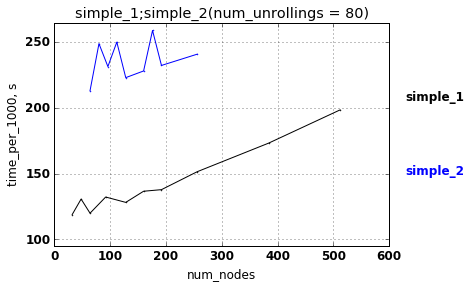

In [14]:
alternative_variable='time_per_1000'
comp.save_several_networks_plot(['simple_1', 'simple_2'],
                                ['num_nodes[0]', 'total_nodes'],
                                [{'num_unrollings': 80}, {'num_unrollings': 80}],
                                'num_nodes',
                                'simple_1;simple_2',
                                [True, True],
                                [True, True],
                                percentage=False,
                                alternative_variable=alternative_variable,
                                show=True)

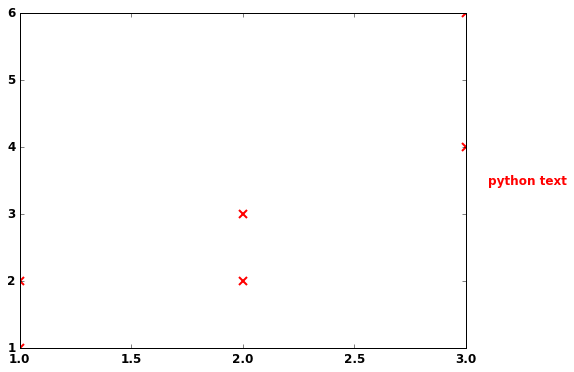

In [201]:
plt.close()
fig = plt.figure(2)
r = fig.canvas.get_renderer()
x = [1, 1, 2, 2, 3, 3]
y = [1, 2, 2, 3, 4, 6]

plt.plot(x, y, marker='x', ms = 8, mew=2, linestyle='None', color='r')
x1, x2, y1, y2 = plt.axis()
text = plt.text(x2 + 0.05 * (x2 - x1), (y1+ y2) / 2, 'python text',  va = 'center', ha = 'left', color='r') 
bbox = text.get_window_extent(renderer = r)
leg =  plt.axes().get_legend()
texts = plt.axes().texts
texts2 = fig.texts
fig.set_size_inches(8, 6, forward = True)
plt.show()
plt.close()


In [1]:
a = {'a': 1, 'b': 2}
print(a.keys())

['a', 'b']
